## POS tagging using modified Viterbi


#### Steps involved:

 1. Vanilla Viterbi Algorithm for assigning POS tags (i.e. without dealing with unknown words)
 2. Viterbi Modification-Approach I:
     - Transition probability is considered in case of unknown words since emission probability is zero.
 3. Viterbi Modification-Approach II:
     - Trigram tagger backed off to a rule based tagger in case of an unknown word.
 4. Compare the tagging accuracy after making these modifications with the vanilla Viterbi algorithm.
 5. Listed down cases which were incorrectly tagged by original Viterbi POS tagger and got corrected after modifications.

### Data Preparation

In [1]:
#Importing libraries
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pprint,time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize


In [2]:
# reading the Treebank tagged sentences
nltk.download('universal_tagset')
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

[nltk_data] Error loading universal_tagset: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


In [3]:
#check the length 
len(nltk_data)

3914

In [4]:
#check the first few tagged sentences
print(nltk_data[:5])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [5]:
#Split data into train and validation set in the ratio of 95:5
random.seed(1234)
train_set, test_set = train_test_split(nltk_data,train_size=0.95, test_size=0.05, random_state=42)

print(len(train_set))
print(len(test_set))

3718
196


In [6]:
# Getting list of tagged words - train data
train_tagged_words = [tup for sent in train_set for tup in sent]
print(len(train_tagged_words))

# Getting list of tagged words - validation data
test_tagged_words = [tup for sent in test_set for tup in sent]
print(len(test_tagged_words))

95589
5087


In [7]:
# tokens. i.e. the list of words from list of (word, tag) fom train set
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['Bank', 'of', 'New', 'England', "'s", 'shares', 'are', 'traded', '*-1', 'on']

In [8]:
#vocabulary
V = set(tokens)
print(len(V))

12109


In [9]:
#number of tags
T = sorted(list(set([pair[1] for pair in train_tagged_words])))
len(T)

12

In [10]:
#check the tags
print(T)

['.', 'ADJ', 'ADP', 'ADV', 'CONJ', 'DET', 'NOUN', 'NUM', 'PRON', 'PRT', 'VERB', 'X']


**Observations:** 

 - The tagset consists of the following 12 coarse tags:


    . - punctuation

    ADJ - adjectives

    ADP - adpositions

    ADV - adverbs

    CONJ - conjunctions

    DET - determiners

    NOUN - nouns

    NUM - cardinal numbers

    PRON - pronouns

    PRT - particles or other function words

    VERB - verbs

    X - other: foreign words, typos, abbreviations

### POS Tagging Algorithm - HMM

 - We'll use the HMM algorithm to tag the words.Given a sequence of words to be tagged, the task is to assign the most probable tag to the word.


 - For each word, we compute the P(tag|word) for each tag in the tag set and then assign the tag having the max P(tag/word).


 - P(tag|word) = (emission probability of the word-tag pair) (transition probability from the previous tag).
    i.e. P(t|w) = P(w|t) P(t2|t1)




 - Emission probability of a word 'w' for tag 't':

    P(w|t)= (No.of times w has been tagged as t)/(No.of times t appears)


 - Transition probability of tag t1 followed by tag t2:

    P(t2|t1)= (No.of times t1 is followed by tag t2)/(No.of times t1 appears)


So, Let us calculate the emission and transition probabilities.

### Emission probabilities

In [11]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [12]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    
    # Calculate no.of times tag t appears
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    
    # Calculate no.of times word w has been tagged as tag t
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [13]:
#Example

print("reported")
print(word_given_tag('reported','NOUN'))
print(word_given_tag('reported','VERB'))
print(word_given_tag('reported','ADJ'))

reported
(0, 27423)
(34, 12885)
(0, 6077)


### Transition Probabilities

In [14]:
# compute tag given tag: tag2(t2) given tag1 (t1) : Transition Probability
def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    
    # Calculate no.of times tag t1 appears
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    
    # Calculate no.of times t1 is followed by tag t2
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [15]:
# examples
print(t2_given_t1('NOUN', 'ADJ'))
print(t2_given_t1('NOUN', 'VERB'))
print(t2_given_t1('VERB', 'NOUN'))


(4234, 6077)
(1429, 12885)
(4058, 27423)


In [16]:
# Please note P(tag|start) is same as P(tag|'.')
print(t2_given_t1('DET', '.'))
print(t2_given_t1('NOUN', '.'))
print(t2_given_t1('VERB', '.'))

(1929, 11118)
(2481, 11118)
(984, 11118)


In [17]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

tags_matrix

array([[9.38118398e-02, 4.49721180e-02, 9.11135077e-02, 5.20777106e-02,
        5.79240881e-02, 1.73502430e-01, 2.23151639e-01, 8.05000886e-02,
        6.53894618e-02, 2.33855005e-03, 8.85051265e-02, 2.66234931e-02],
       [6.53282851e-02, 6.66447282e-02, 7.89863393e-02, 4.60753683e-03,
        1.69491526e-02, 5.10120112e-03, 6.96725368e-01, 2.04048045e-02,
        6.58219506e-04, 1.08606219e-02, 1.23416157e-02, 2.13921349e-02],
       [3.94863561e-02, 1.05296947e-01, 1.72284637e-02, 1.31621184e-02,
        8.56072758e-04, 3.26377749e-01, 3.21776360e-01, 6.29213452e-02,
        6.91278726e-02, 1.49812736e-03, 8.23970046e-03, 3.40288915e-02],
       [1.36877075e-01, 1.30232558e-01, 1.19601332e-01, 8.10631216e-02,
        6.31229253e-03, 6.71096370e-02, 3.08970101e-02, 3.05647831e-02,
        1.56146176e-02, 1.36212623e-02, 3.44518274e-01, 2.35880390e-02],
       [3.42562161e-02, 1.16846554e-01, 5.44345379e-02, 5.58423288e-02,
        4.69263265e-04, 1.21539183e-01, 3.49131852e-01, 4.22

In [18]:
# convert the matrix to a dataframe for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))
tags_df

,.,ADJ,ADP,ADV,CONJ,DET,NOUN,NUM,PRON,PRT,VERB,X
.,0.093812,0.044972,0.091114,0.052078,0.057924,0.173502,0.223152,0.080500,0.065389,0.002339,0.088505,0.026623
ADJ,0.065328,0.066645,0.078986,0.004608,0.016949,0.005101,0.696725,0.020405,0.000658,0.010861,0.012342,0.021392
ADP,0.039486,0.105297,0.017228,0.013162,0.000856,0.326378,0.321776,0.062921,0.069128,0.001498,0.008240,0.034029
ADV,0.136877,0.130233,0.119601,0.081063,0.006312,0.067110,0.030897,0.030565,0.015615,0.013621,0.344518,0.023588
CONJ,0.034256,0.116847,0.054435,0.055842,0.000469,0.121539,0.349132,0.042234,0.058658,0.004693,0.153918,0.007977
DET,0.017986,0.204973,0.009054,0.012313,0.000483,0.005311,0.640029,0.021970,0.003742,0.000241,0.038387,0.045509
NOUN,0.239179,0.012289,0.176275,0.016884,0.041936,0.013310,0.264632,0.009627,0.004923,0.043832,0.147978,0.029136
NUM,0.118347,0.034196,0.034790,0.002974,0.013381,0.003271,0.355338,0.184062,0.001487,0.027951,0.017544,0.206661
PRON,0.041253,0.074866,0.022918,0.033995,0.004966,0.009549,0.211230,0.007257,0.008021,0.012223,0.480901,0.092819
PRT,0.041517,0.086303,0.021576,0.010134,0.002288,0.100360,0.242563,0.058516,0.018960,0.001635,0.402746,0.013403


In [19]:
tags_df.loc['.', :]

.       0.093812
ADJ     0.044972
ADP     0.091114
ADV     0.052078
CONJ    0.057924
DET     0.173502
NOUN    0.223152
NUM     0.080500
PRON    0.065389
PRT     0.002339
VERB    0.088505
X       0.026623
Name: ., dtype: float32

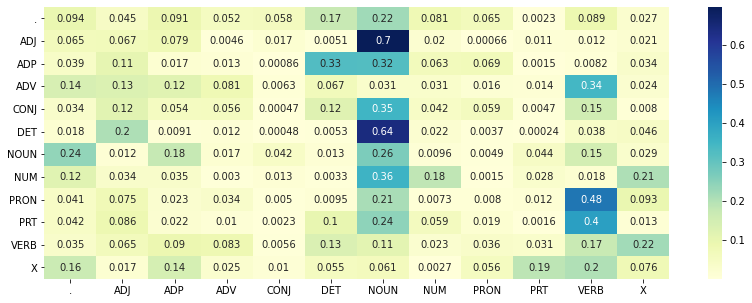

In [20]:
# heatmap of tags matrix
plt.figure(figsize=(14, 5))
sns.heatmap(tags_df, annot=True,cmap="YlGnBu")
plt.show()

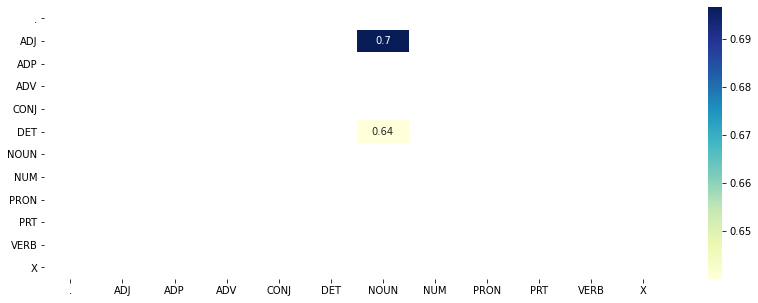

In [21]:
# filter df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(14,5))
sns.heatmap(tags_frequent,annot = True,cmap="YlGnBu")
plt.show()

**Observations:** 

 - As seen from above heatmap,most of the transition probabilities are between Noun and other parts of speech such as Adjective and Determinant.

### Build the vanilla Viterbi based POS tagger


Let's now use the computed probabilities P(w, tag) and P(t2, t1) to assign tags to each word in the document. We'll run through each word w and compute P(tag/w)=P(w/tag).P(tag) for each tag in the tag set, and then assign the tag having the max P(tag/w).

We'll store the assigned tags in a list of tuples, similar to the list 'train_tagged_words'. Each tuple will be a (token, assigned_tag). As we progress further in the list, each tag to be assigned will use the tag of the previous token.

In [22]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    
    # list of unique tags present in the corpus
    T = sorted(list(set([pair[1] for pair in train_bag])))
        
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = []
        
        for tag in T:
            if key == 0: #first word has key=0
                transition_p = tags_df.loc['.', tag]                 
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)]
        state.append(state_max)
    return list(zip(words, state))

In [23]:
# Let's test our Viterbi algorithm on the validation dataset which is 5% of the entire dataset

random.seed(1234)


# list of tagged words
test_run_base = [tup for sent in test_set for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_set for tup in sent]

In [24]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

In [25]:
print("Time taken in seconds: ", difference)

Time taken in seconds:  1180.2186784744263


In [26]:
# Let's check the accuracy of the vanilla viterbi algorithm
vanilla_viterbi_word_check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
vanilla_viterbi_accuracy = len(vanilla_viterbi_word_check)/len(tagged_seq)
print("The accuracy of the Vanilla Viterbi Algorithm is -", vanilla_viterbi_accuracy)

The accuracy of the Vanilla Viterbi Algorithm is - 0.9138981718104974


In [27]:
# let's check the incorrectly tagged words
incorrect_tagged_words = [j for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0] != j[1]]

print("Total Incorrect Tagged Words :", len(incorrect_tagged_words))
print("\n")
print("Incorrect Tagged Words :", incorrect_tagged_words)

Total Incorrect Tagged Words : 438


Incorrect Tagged Words : [(('trade', 'VERB'), ('trade', 'NOUN')), (('Overseas', '.'), ('Overseas', 'NOUN')), (('Private', 'ADJ'), ('Private', 'NOUN')), (('pre-1917', '.'), ('pre-1917', 'ADJ')), (('Unemployment', '.'), ('Unemployment', 'NOUN')), (('purchasing', 'NOUN'), ('purchasing', 'VERB')), (('paycheck', '.'), ('paycheck', 'NOUN')), (('reasonably', '.'), ('reasonably', 'ADV')), (('though', 'ADP'), ('though', 'ADV')), (('close', 'NOUN'), ('close', 'ADJ')), (('more', 'ADV'), ('more', 'ADJ')), (('Funded', '.'), ('Funded', 'VERB')), (('Tokio', '.'), ('Tokio', 'NOUN')), (('protocols', '.'), ('protocols', 'NOUN')), (('preventative', '.'), ('preventative', 'ADJ')), (('existed', '.'), ('existed', 'VERB')), (('20.5', '.'), ('20.5', 'NUM')), (('polarized', '.'), ('polarized', 'VERB')), (('so', 'ADV'), ('so', 'ADP')), (('exists', '.'), ('exists', 'VERB')), (('middle', 'NOUN'), ('middle', 'ADJ')), (('Though', '.'), ('Though', 'ADP')), (('acquirers', '.'), ('

### Solve the problem of unknown words

### Viterbi Modification-Technique I

The default Vanilla viterbi algorithm achieved an accuracy of about 91.39%. The incorrect tagged cases can be attributed to the fact that when the algorithm hits an unknown word (i.e. not present in the training set hence emission probability is 0), it naively assigns the first tag in the list of tags that we have created.


To minimize this 9% loss of accuracy, we modify the vanilla viterbi.We Use transition probability of tags when emission probability is zero (in case of unknown words)


If a word is not present in the training vocabulary i.e. unknown word, then its emission probability will be 0 and hence The state probability will also be zero. Therefore in cases where the algorithm encounters a word which it has not see previously, we can leave out the emission probability and consider only the transition probability.

The vanilla viterbi algorithm can be modified as shown below:

If word is unknown then,
consider only the transition prob (since, emission probability will be 0)
Else
consider both the emission and transition probabilities as state probability.

In [28]:
# Modified Viterbi Heuristic- Approach I
def Viterbi_approach1(words, train_bag = train_tagged_words):
    state = []
    
    # Take the list of unique tags present in the corpus
    T = sorted(list(set([pair[1] for pair in train_bag])))
    V = [i[0] for i in train_bag]
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        
        for tag in T:
            if key == 0: #first word has key=0
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            
            # modification to the original vanilla viterbi algorithm. 
            # Vocab contains the list of unique words in training dataset
            if word not in V: 
                state_probability = transition_p
            else:
                state_probability = emission_p * transition_p
                
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [29]:
# tagging the test sentences
start = time.time()
unknown_word_tagged_seq = Viterbi_approach1(test_tagged_words)
end = time.time()
difference = end-start

In [30]:
print("Time taken in seconds: ", difference)

Time taken in seconds:  1188.9404582977295


In [31]:
#Let's check the accuracy of the Vanilla Viterbi Algorithm after modification
unknown_word_check = [i for i, j in zip(unknown_word_tagged_seq, test_run_base) if i == j]

optimized_viterbi_accuracy = len(unknown_word_check)/len(unknown_word_tagged_seq)

print("The accuracy of the Vanilla Viterbi Algorithm after modification to handle unknown words is -", optimized_viterbi_accuracy)

The accuracy of the Vanilla Viterbi Algorithm after modification to handle unknown words is - 0.9388637703951248


In [32]:
incorrect_tagged_unknown_word = [j for i, j in enumerate(zip(unknown_word_tagged_seq, test_run_base)) if j[0]!=j[1]]
print("Total Incorrect Tagged Words :", len(incorrect_tagged_unknown_word))
print("\n")
print("Incorrect Tagged Words :", incorrect_tagged_unknown_word)

Total Incorrect Tagged Words : 311


Incorrect Tagged Words : [(('trade', 'VERB'), ('trade', 'NOUN')), (('Private', 'ADJ'), ('Private', 'NOUN')), (('pre-1917', 'X'), ('pre-1917', 'ADJ')), (('purchasing', 'NOUN'), ('purchasing', 'VERB')), (('reasonably', 'NOUN'), ('reasonably', 'ADV')), (('though', 'ADP'), ('though', 'ADV')), (('close', 'NOUN'), ('close', 'ADJ')), (('more', 'ADV'), ('more', 'ADJ')), (('Tokio', 'DET'), ('Tokio', 'NOUN')), (('preventative', 'DET'), ('preventative', 'ADJ')), (('20.5', 'NOUN'), ('20.5', 'NUM')), (('polarized', 'X'), ('polarized', 'VERB')), (('so', 'ADV'), ('so', 'ADP')), (('middle', 'NOUN'), ('middle', 'ADJ')), (('Though', 'NOUN'), ('Though', 'ADP')), (('154.2', 'X'), ('154.2', 'NUM')), (('chalk', 'DET'), ('chalk', 'NOUN')), (('first', 'ADJ'), ('first', 'ADV')), (('touched', 'NOUN'), ('touched', 'VERB')), (('cross-border', 'DET'), ('cross-border', 'ADJ')), (('emigres', 'DET'), ('emigres', 'NOUN')), (('*T*-133', 'NOUN'), ('*T*-133', 'X')), (('checking', 'NOU

**Observations:** 

 - Modified viterbi algorithm performs better than the original vanilla viterbi algorithm. The modified viterbi achieves an accuracy of approx. 93.88% compared to 91.39% of the vanilla viterbi algorithm.


| Incorrect Tags-Original POS Tagger | Corrected Tags-Modified Approach I |
| --- | --- |
| ('protocols', '.') | ('protocols', 'NOUN') |
| ('existed', '.') | ('existed', 'VERB') |
| ('indulging', '.') | ('indulging', 'VERB') |
| ('spurned', '.') | ('spurned', 'VERB') |
| ('paycheck', '.') | ('paycheck', 'NOUN') |


#### Lexicon and Rule-Based Models for POS Tagging

In [33]:
# Lexicon (or unigram tagger)
unigram_tagger = nltk.UnigramTagger(train_set)
accuracy_unigram_tagger = unigram_tagger.evaluate(test_set)
print("The accuracy of the Unigram Tagger is -", accuracy_unigram_tagger)

The accuracy of the Unigram Tagger is - 0.911735797129939


In [34]:
# patterns for tagging using a rule based tagger
patterns = [
    (r'.*\'s$', 'NOUN'),                     # possessive nouns
    (r'.*s$', 'NOUN'),                       # plural nouns
    (r'^[aA-zZ].*[0-9]+','NOUN'),            # Alpha Numeric
    (r'.*ness$', 'NOUN'),                    # words ending with 'ness' such as 'sluggishness' 
    (r'.*', 'NOUN'), 
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'),     
    (r'[aA-zZ]+(ed|ing|es)$', 'VERB'),       # words ending with 'ed' or 'ing' or 'es'    
    (r'.*ly$', 'ADV'),                       # words ending with 'ly'    
    (r'^[0-9]+(.[0-9]+)?$', 'NUM'),          # cardinal numbers such as 61, 1956, 9.8, 8.45, 352.7        
    (r'(The|the|A|a|An|an)$', 'DET')
    ]

In [35]:
# Rule based tagger
rule_based_tagger = nltk.RegexpTagger(patterns)

# unigram tagger backed up by the rule-based tagger
rule_based_unigram_tagger = nltk.UnigramTagger(train_set, backoff = rule_based_tagger)

accuracy_rule_based_unigram_tagger = rule_based_unigram_tagger.evaluate(test_set)

print("The accuracy of the Unigram Tagger backed up by the RegexpTagger is -", accuracy_rule_based_unigram_tagger)

The accuracy of the Unigram Tagger backed up by the RegexpTagger is - 0.9378808728130529


In [36]:
# Bigram tagger backed up by the rule-based-unigram tagger
bigram_tagger = nltk.BigramTagger(train_set, backoff = rule_based_unigram_tagger)
accuracy_bigram_tagger = bigram_tagger.evaluate(test_set)
print("The accuracy of the Bigram tagger backed up by the rule-based-unigram tagger -", accuracy_bigram_tagger)

The accuracy of the Bigram tagger backed up by the rule-based-unigram tagger - 0.9412227245920975


In [37]:
#trigram tagger
trigram_tagger = nltk.TrigramTagger(train_set, backoff = bigram_tagger)
accuracy_trigram_tagger = trigram_tagger.evaluate(test_set)
print("The accuracy of the Trigram Tagger backed up by the bigram_tagger is -", accuracy_trigram_tagger)

The accuracy of the Trigram Tagger backed up by the bigram_tagger is - 0.9404364065264399


### Viterbi Modification-Technique II

Trigram Tagger backed up by the bigram tagger gives an accuracy of about 94.04%. Let's now try to modify the viterbi algorithm to use this trigram tagger as a back-off.

When the viterbi algorithm is not able to tag an unknown word, it uses the rule-based tagger.

In [38]:
# A trigram tagger backed off by a rule based tagger.

def trigram_tagger(word, train_set = train_set):
    
    # specify patterns for tagging. I have identified most of the patterns from the first 100 sentences in universal dataset
    patterns = [
    (r'^([0-9]|[aA-zZ])+\-([0-9]|[aA-zZ])*$','ADJ'), # words such as '10-lap','30-day','York-based'
    (r'.*able$', 'ADJ'),                     # words ending with 'able' such as 'questionable'
    (r'.*ful$', 'ADJ'),                      # words ending with 'ful' such as 'useful'
    (r'.*ous$', 'ADJ'),                      # words ending with 'ous' such as 'Previous'
    
    (r'.*\'s$', 'NOUN'),                     # possessive nouns
    (r'.*s$', 'NOUN'),                       # plural nouns
    (r'^[aA-zZ].*[0-9]+','NOUN'),            # Alpha Numeric such as Door Number, Street Number etc
    (r'.*ers$', 'NOUN'),                     # words ending with 'ers' such as 'filters','workers'
    (r'.*ment$', 'NOUN'),                    # words ending with 'ment' such as 'reinvestment' a
    (r'.*town$', 'NOUN'),                    # words ending with 'town' such as 'town','downtown'  
    (r'.*ness$', 'NOUN'),                    # words ending with 'ness' such as 'sluggishness' 
    (r'^[A-Z]+([a-z]{1,2})?\.?$','NOUN'),    # words such as 'Nov.','Mr.','Inc.'
    
    (r'[aA-zZ]+(ed|ing|es)$', 'VERB'),       # words ending with 'ed' or 'ing' or 'es'    
    (r'.*ly$', 'ADV'),                       # words ending with 'ly'
    (r'^[0-9]+(.[0-9]+)?$', 'NUM'),          # cardinal numbers such as 61, 1956, 9.8, 8.45, 352.7        
    (r'^(0|([*|-|$].*))','X'),               # words such as '*', '0', *-1', '*T*-1', '*ICH*-1', '*?*'   
    
    (r'(The|the|A|a|An|an|That|that|This|this|Those|those|These|these)$', 'DET'), # determinants     
    (r'.*', 'NOUN')  
    ]
    
    rule_based_tagger = nltk.RegexpTagger(patterns)

    # trigram backed up by the regex tagger
    trigram_regex_tagger = nltk.TrigramTagger(train_set, backoff = rule_based_tagger)
    return trigram_regex_tagger.tag_sents([[(word)]]) 

In [39]:
# Modified Viterbi Heuristic- Approach II - Backoff to rule based tagger in case an unknown word is encountered.
def viterbi_backedup_by_trigram_tagger(words, train_bag = train_tagged_words):
    state = []
    T = sorted(list(set([pair[1] for pair in train_bag])))
    V = [i[0] for i in train_bag]
    
    # use the trigram tagger backed up by the rule based tagger for unknown words.
    for key, word in enumerate(words):
        if word not in V:
            unknown_word_tag = trigram_tagger(word)
            for sent in unknown_word_tag:
                for tup in sent:
                    state.append(tup[1])
        else:            
            p = [] 
            for tag in T:
                if key == 0:
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[state[-1], tag]
                
                # compute emission and state probabilities
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
                state_probability = emission_p * transition_p    
                p.append(state_probability)
            
            pmax = max(p)
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)] 
            state.append(state_max)
    return list(zip(words, state))

#### Evaluating tagging accuracy

In [40]:
# tagging the test sentences
viterbi_trigram_tagged_seq = viterbi_backedup_by_trigram_tagger(test_tagged_words)

# accuracy
viterbi_trigram_word_check = [i for i, j in zip(viterbi_trigram_tagged_seq, test_run_base) if i == j]

viterbi_trigram_accuracy = len(viterbi_trigram_word_check)/len(viterbi_trigram_tagged_seq)

print("The accuracy of the viterbi_backedup_by_trigram_tagger is -", viterbi_trigram_accuracy)

The accuracy of the viterbi_backedup_by_trigram_tagger is - 0.9618635738156084


In [41]:
viterbi_trigram_incorrect_tagged_cases = [j for i, j in enumerate(zip(viterbi_trigram_tagged_seq, test_run_base)) if j[0]!=j[1]]

In [42]:
print("Total Incorrect Tagged Words :", len(viterbi_trigram_incorrect_tagged_cases))
print("\n")
print("Incorrect Tagged Words :", viterbi_trigram_incorrect_tagged_cases)

Total Incorrect Tagged Words : 194


Incorrect Tagged Words : [(('trade', 'VERB'), ('trade', 'NOUN')), (('Private', 'ADJ'), ('Private', 'NOUN')), (('purchasing', 'NOUN'), ('purchasing', 'VERB')), (('though', 'ADP'), ('though', 'ADV')), (('close', 'NOUN'), ('close', 'ADJ')), (('more', 'ADV'), ('more', 'ADJ')), (('preventative', 'NOUN'), ('preventative', 'ADJ')), (('so', 'ADV'), ('so', 'ADP')), (('exists', 'NOUN'), ('exists', 'VERB')), (('middle', 'NOUN'), ('middle', 'ADJ')), (('Though', 'NOUN'), ('Though', 'ADP')), (('first', 'ADJ'), ('first', 'ADV')), (('Catch-22', 'ADJ'), ('Catch-22', 'NOUN')), (('checking', 'NOUN'), ('checking', 'VERB')), (('safe', 'NOUN'), ('safe', 'ADJ')), (('plus', 'CONJ'), ('plus', 'ADV')), (('homeless', 'ADJ'), ('homeless', 'NOUN')), (('up', 'ADV'), ('up', 'PRT')), (('most', 'ADJ'), ('most', 'ADV')), (('that', 'ADP'), ('that', 'DET')), (('exploit', 'NOUN'), ('exploit', 'VERB')), (('brief', 'VERB'), ('brief', 'ADJ')), (('as', 'ADP'), ('as', 'ADV')), (('test', 'VE

**Observations:** 

 - Below words have been correctly tagged by Approach II compared to Vanilla viterbi and Modified Approach-I.


| Incorrect Tags-Original POS Tagger | Corrected Tags-Modified Approach I | Corrected Tags-Modified Approach II |
| --- | --- | --- |
| ('reasonably', '.') | ('reasonably', 'NOUN') | ('reasonably', 'ADV') |
| ('154.2', '.') | ('154.2', 'X') | ('154.2', 'NUM') |
| ('Tokio', '.') | ('Tokio', 'DET') | ('Tokio', 'NOUN') |
| ('polarized', '.') | ('polarized', 'X') | ('polarized', 'VERB') |

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [43]:
acccuracy_data = [['Vanilla Viterbi', vanilla_viterbi_accuracy*100], 
                  ['Optimized Vanilla Viterbi', optimized_viterbi_accuracy*100], 
                  ['Unigram Tagger', accuracy_unigram_tagger*100],
                  ['Unigram + RegexpTagger', accuracy_rule_based_unigram_tagger*100],
                  ['Bigram Tagger + Unigram_tagger', accuracy_bigram_tagger*100],
                  ['Trigram Tagger + Bigram_tagger', accuracy_trigram_tagger*100],
                  ['Viterbi + Trigram_tagger', viterbi_trigram_accuracy*100]]

acccuracy_data_df = pd.DataFrame(acccuracy_data, columns = ['Tagging_Algorithm', 'Tagging_Accuracy'])

acccuracy_data_df

,Tagging_Algorithm,Tagging_Accuracy
0,Vanilla Viterbi,91.389817
1,Optimized Vanilla Viterbi,93.886377
2,Unigram Tagger,91.173580
3,Unigram + RegexpTagger,93.788087
4,Bigram Tagger + Unigram_tagger,94.122272
5,Trigram Tagger + Bigram_tagger,94.043641
6,Viterbi + Trigram_tagger,96.186357


### List down cases which were incorrectly tagged by original POS tagger and got corrected by our modifications

#### Case#1

In [44]:
sentence_test1 = 'I Instagrammed a Facebook post taken from Android smartphone and uploaded results to Youtube.'
words = word_tokenize(sentence_test1)
tagged_seq = Viterbi(words)
print(tagged_seq)

[('I', 'PRON'), ('Instagrammed', '.'), ('a', 'DET'), ('Facebook', '.'), ('post', 'NOUN'), ('taken', 'VERB'), ('from', 'ADP'), ('Android', '.'), ('smartphone', '.'), ('and', 'CONJ'), ('uploaded', '.'), ('results', 'NOUN'), ('to', 'PRT'), ('Youtube', '.'), ('.', '.')]


In [45]:
tagged_seq_modified1 = Viterbi_approach1(words)
print(tagged_seq_modified1)

[('I', 'PRON'), ('Instagrammed', 'VERB'), ('a', 'DET'), ('Facebook', 'NOUN'), ('post', 'NOUN'), ('taken', 'VERB'), ('from', 'ADP'), ('Android', 'DET'), ('smartphone', 'NOUN'), ('and', 'CONJ'), ('uploaded', 'NOUN'), ('results', 'NOUN'), ('to', 'PRT'), ('Youtube', 'VERB'), ('.', '.')]


In [46]:
tagged_seq_modified2 = viterbi_backedup_by_trigram_tagger(words)
print(tagged_seq_modified2)

[('I', 'PRON'), ('Instagrammed', 'VERB'), ('a', 'DET'), ('Facebook', 'NOUN'), ('post', 'NOUN'), ('taken', 'VERB'), ('from', 'ADP'), ('Android', 'NOUN'), ('smartphone', 'NOUN'), ('and', 'CONJ'), ('uploaded', 'VERB'), ('results', 'NOUN'), ('to', 'PRT'), ('Youtube', 'NOUN'), ('.', '.')]


**Observations:** 

 - Below words have been correctly tagged by Approach II compared to Modified Approach-I.


| Incorrect Tags-Original POS Tagger | Corrected Tags-Modified Approach I | Corrected Tags-Modified Approach II |
| --- | --- | --- |
| ('Instagrammed', '.') | ('Instagrammed', 'VERB') | ('Instagrammed', 'VERB') |
| ('Facebook', '.') | ('Facebook', 'NOUN') | ('Facebook', 'NOUN') |
| ('Android', '.') | ('Android', 'DET') | ('Android', 'NOUN') |
| ('smartphone', '.') | ('smartphone', 'NOUN') | ('smartphone', 'NOUN') |
| ('uploaded', '.') | ('uploaded', 'NOUN') | ('uploaded', 'VERB') |
| ('Youtube', '.') | ('Youtube', 'VERB') | ('Youtube', 'NOUN') |


#### Case#2

In [47]:
sentence_test2 = "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose."
words = word_tokenize(sentence_test2)
tagged_seq = Viterbi(words)
print(tagged_seq)

[('Google', '.'), ('and', 'CONJ'), ('Twitter', '.'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', '.'), ('that', 'DET'), ('gave', 'VERB'), ('Google', '.'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', '.'), ("'s", 'VERB'), ('firehose', '.'), ('.', '.')]


In [48]:
tagged_seq_modified1 = Viterbi_approach1(words)
print(tagged_seq_modified1)

[('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'DET'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'X'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'VERB'), ("'s", 'PRT'), ('firehose', 'VERB'), ('.', '.')]


In [49]:
tagged_seq_modified2 = viterbi_backedup_by_trigram_tagger(words)
print(tagged_seq_modified2)

[('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.')]


**Observations:** 

 - Below words have been correctly tagged by Approach II compared to Modified Approach-I.


| Incorrect Tags-Original POS Tagger | Corrected Tags-Modified Approach I | Corrected Tags-Modified Approach II |
| --- | --- | --- |
| ('Google', '.') | ('Google', 'NOUN') | ('Google', 'NOUN') |
| ('Twitter', '.') | ('Twitter', 'NOUN') | ('Twitter', 'NOUN') |
| ('2015', '.') | ('2015', 'DET') | ('2015', 'DET') |
| ('that', 'DET') | ('that', 'ADP') | ('that', 'ADP') |
| ('Google', '.') | ('Google', 'X') | ('Google', 'NOUN') |
| ('Twitter', '.') | ('Twitter', 'VERB') | ('Twitter', 'NOUN') |
| (''s', 'VERB') | (''s', 'PRT') | (''s', 'PRT') |
| ('firehose', '.') | ('firehose', 'VERB') | ('firehose', 'NOUN') |

#### Case#3

In [50]:
sentence_test3 = 'NASA invited social media users to experience the launch of ICESAT-2 Satellite.'
words = word_tokenize(sentence_test3)
tagged_seq = Viterbi(words)
print(tagged_seq)

[('NASA', '.'), ('invited', '.'), ('social', 'ADJ'), ('media', 'NOUN'), ('users', 'NOUN'), ('to', 'PRT'), ('experience', 'NOUN'), ('the', 'DET'), ('launch', 'NOUN'), ('of', 'ADP'), ('ICESAT-2', '.'), ('Satellite', '.'), ('.', '.')]


In [51]:
tagged_seq_modified1 = Viterbi_approach1(words)
print(tagged_seq_modified1)

[('NASA', 'NOUN'), ('invited', 'NOUN'), ('social', 'ADJ'), ('media', 'NOUN'), ('users', 'NOUN'), ('to', 'PRT'), ('experience', 'NOUN'), ('the', 'DET'), ('launch', 'NOUN'), ('of', 'ADP'), ('ICESAT-2', 'DET'), ('Satellite', 'NOUN'), ('.', '.')]


In [52]:
tagged_seq_modified2 = viterbi_backedup_by_trigram_tagger(words)
print(tagged_seq_modified2)

[('NASA', 'NOUN'), ('invited', 'VERB'), ('social', 'ADJ'), ('media', 'NOUN'), ('users', 'NOUN'), ('to', 'PRT'), ('experience', 'NOUN'), ('the', 'DET'), ('launch', 'NOUN'), ('of', 'ADP'), ('ICESAT-2', 'ADJ'), ('Satellite', 'NOUN'), ('.', '.')]


**Observations:** 

 - Below words have been correctly tagged by Approach II compared to Modified Approach-I.


| Incorrect Tags-Original POS Tagger | Corrected Tags-Modified Approach I | Corrected Tags-Modified Approach II |
| --- | --- | --- |
| ('NASA', '.') | ('NASA', 'NOUN') | ('NASA', 'NOUN') |
| ('invited', '.') | ('invited', 'NOUN') | ('invited', 'VERB') |
| ('ICESAT-2', '.') | ('ICESAT-2', 'DET') | ('ICESAT-2', 'ADJ') |
| ('Satellite', '.') | ('Satellite', 'NOUN') | ('Satellite', 'NOUN') |


### CONCLUSION -

In this analysis,we used 2 modification techniques for the original vanilla viterbi .
    1. Viterbi Modification-Technique I: 
        - Here we used only the transition probability for unknown words
        - Achieved an accuracy of around 93.88%
        
    2. Viterbi Modification-Technique II: 
        - we used viterbi algorithm and backed it up with trigram tagger which was backed up by rule-based regex tagger.
        - Achieved an accuracy of around 96.19%

Most of the words that were incorrectly tagged by the vanilla viterbi algorithm were corrected by the viterbi algorithm backed up by the trigram tagger.
